In [116]:
from __future__ import print_function, division

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [118]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "data/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160903, 160910, 160917]
turnstiles_df = get_data(week_nums)

In [119]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

turnstiles_df["DOW_INDEX"] = turnstiles_df["DATE_TIME"].apply(lambda x: x.weekday())

# let's see if 9:00 can be mapped to 8:00

In [120]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

# Drop irregular times
turnstiles_df = turnstiles_df[[time[3:5] == "00" and time[6:] == "00" for time in turnstiles_df["TIME"]]]

In [169]:
# see if odd times can coincide with even times
turnstiles_by_date = (turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False))["TIME"]

count = 0
for key, group in turnstiles_by_date:
    hours = list(map(lambda x: int(x[:2]), group["TIME"]))
    #a = sum(np.array(hours) % 2 == 0)
    #b = sum(np.array(hours) % 2 == 1)
    #a = sum(np.array(hours) % 4 == 2)
    #b = sum(np.array(hours) % 4 == 0)
    offset = np.unique(np.array(hours) % 4)
    if len(offset) > 1:
        count += 1
        print(offset)
assert(count == 0)
count # looks like there's no conflicts if we move back the odd times by one hour and lump them with the evens
      # as well as if we move the 2 mod 4 times back to 0 mod 4

0

In [174]:
# lump odd times with evens

# this might be a little wonky
turnstiles_df["TIME"] = turnstiles_df["TIME"].apply(lambda x: str(int(x[:2])-1).zfill(2) + x[2:] if (int(x[:2]) % 2 == 1) else x)
turnstiles_df["TIME"] = turnstiles_df["TIME"].apply(lambda x: str(int(x[:2])-2).zfill(2) + x[2:] if (int(x[:2]) % 4 == 2) else x)

# may want to fix DATE_TIME later
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df["DATE"] + " " + turnstiles_df["TIME"], 
                                            format="%m/%d/%Y %H:%M:%S")


In [175]:
turnstiles_hourly = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "DATE", "TIME"],as_index=False)
                        .ENTRIES.first())


# note that our days must be consecutive, else for late-night entries we get inaccurate counts
turnstiles_hourly[["NEXT_HOUR", "NEXT_ENTRIES"]] = turnstiles_hourly.groupby(["C/A", "UNIT", "SCP", "STATION"])\
                                                                    [["DATE_TIME", "ENTRIES"]]\
                                                                    .apply(lambda grp: grp.shift(-1))

turnstiles_hourly.dropna(subset=["NEXT_HOUR"], axis=0, inplace=True)

In [176]:
def get_hourly_counts(row, max_counter):
    counter = row["NEXT_ENTRIES"] - row["ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["NEXT_ENTRIES"])
        return 0
    return counter

# some exploration indicates anything above 4800 is faulty data
turnstiles_hourly["HOURLY_ENTRIES"] = turnstiles_hourly.apply(get_hourly_counts, axis=1, max_counter=4800)


In [177]:
turnstiles_hourly

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,ENTRIES,NEXT_HOUR,NEXT_ENTRIES,HOURLY_ENTRIES
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,08/27/2016,00:00:00,5799442,2016-08-27 04:00:00,5799463.0,21.0
1,A002,R051,02-00-00,59 ST,2016-08-27 04:00:00,08/27/2016,04:00:00,5799463,2016-08-27 08:00:00,5799492.0,29.0
2,A002,R051,02-00-00,59 ST,2016-08-27 08:00:00,08/27/2016,08:00:00,5799492,2016-08-27 12:00:00,5799610.0,118.0
3,A002,R051,02-00-00,59 ST,2016-08-27 12:00:00,08/27/2016,12:00:00,5799610,2016-08-27 16:00:00,5799833.0,223.0
4,A002,R051,02-00-00,59 ST,2016-08-27 16:00:00,08/27/2016,16:00:00,5799833,2016-08-27 20:00:00,5800121.0,288.0
...,...,...,...,...,...,...,...,...,...,...,...
534329,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2016-09-16 00:00:00,09/16/2016,00:00:00,5554,2016-09-16 04:00:00,5554.0,0.0
534330,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2016-09-16 04:00:00,09/16/2016,04:00:00,5554,2016-09-16 08:00:00,5554.0,0.0
534331,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2016-09-16 08:00:00,09/16/2016,08:00:00,5554,2016-09-16 12:00:00,5554.0,0.0
534332,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2016-09-16 12:00:00,09/16/2016,12:00:00,5554,2016-09-16 16:00:00,5554.0,0.0


In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [179]:
# first get hourly entries by station
stations_hourly = \
(turnstiles_hourly.groupby(['STATION','DATE_TIME', 'DATE', 'TIME'])['HOURLY_ENTRIES'].sum()
                 .reset_index())

stations_hourly["DOW_INDEX"] = stations_hourly["DATE_TIME"].apply(lambda x: x.weekday())
stations_hourly

,STATION,DATE_TIME,DATE,TIME,HOURLY_ENTRIES,DOW_INDEX
0,1 AV,2016-08-27 00:00:00,08/27/2016,00:00:00,1541.0,5
1,1 AV,2016-08-27 04:00:00,08/27/2016,04:00:00,544.0,5
2,1 AV,2016-08-27 08:00:00,08/27/2016,08:00:00,4586.0,5
3,1 AV,2016-08-27 12:00:00,08/27/2016,12:00:00,2007.0,5
4,1 AV,2016-08-27 16:00:00,08/27/2016,16:00:00,4007.0,5
...,...,...,...,...,...,...
44208,ZEREGA AV,2016-09-16 00:00:00,09/16/2016,00:00:00,57.0,4
44209,ZEREGA AV,2016-09-16 04:00:00,09/16/2016,04:00:00,1293.0,4
44210,ZEREGA AV,2016-09-16 08:00:00,09/16/2016,08:00:00,477.0,4
44211,ZEREGA AV,2016-09-16 12:00:00,09/16/2016,12:00:00,589.0,4


In [186]:
# find a better way to do this. can seaborn support tuples as values?
stations_hourly["DOW_TIME"] = stations_hourly["DATE_TIME"].apply(lambda x: x.dayofweek + x.hour/24)
stations_hourly["DOW_TIME"].unique()

array([5.        , 5.16666667, 5.33333333, 5.5       , 5.66666667,
       5.83333333, 6.        , 6.16666667, 6.33333333, 6.5       ,
       6.66666667, 6.83333333, 0.        , 0.16666667, 0.33333333,
       0.5       , 0.66666667, 0.83333333, 1.        , 1.16666667,
       1.33333333, 1.5       , 1.66666667, 1.83333333, 2.        ,
       2.16666667, 2.33333333, 2.5       , 2.66666667, 2.83333333,
       3.        , 3.16666667, 3.33333333, 3.5       , 3.66666667,
       3.83333333, 4.        , 4.16666667, 4.33333333, 4.5       ,
       4.66666667, 4.83333333])

In [288]:
top_stations = ['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 '14 ST-UNION SQ',
 '86 ST',
 '42 ST-PORT AUTH',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '125 ST']
top_stations_afternoon = ['GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 '34 ST-PENN STA',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '59 ST',
 'CANAL ST',
 '47-50 STS ROCK',
 '86 ST',
 '59 ST COLUMBUS',
 'CHAMBERS ST',
 '42 ST-PORT AUTH',
 '14 ST']
top_stations_morning = ['34 ST-PENN STA',
 '42 ST-PORT AUTH',
 '86 ST',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 'FLUSHING-MAIN',
 '125 ST',
 '96 ST',
 'JKSN HT-ROOSVLT',
 '14 ST-UNION SQ',
 'FULTON ST',
 'TIMES SQ-42 ST',
 '59 ST',
 '145 ST']
top_stations_all = np.unique(top_stations_morning + top_stations_afternoon)

In [311]:
stations_dow_time = (stations_hourly.groupby(["STATION", "DOW_TIME"])).mean()
top_stations_dow_time = stations_dow_time.loc[top_stations_morning].reset_index()
len(top_stations_all)

12

In [312]:
top_stations_dow_time_drop = top_stations_dow_time[[elem % 1 > 0.2 and elem % 1 < 0.8 and elem % 1 != 0.5 for elem in top_stations_dow_time["DOW_TIME"]]]

[(0.0, 80000.0)]

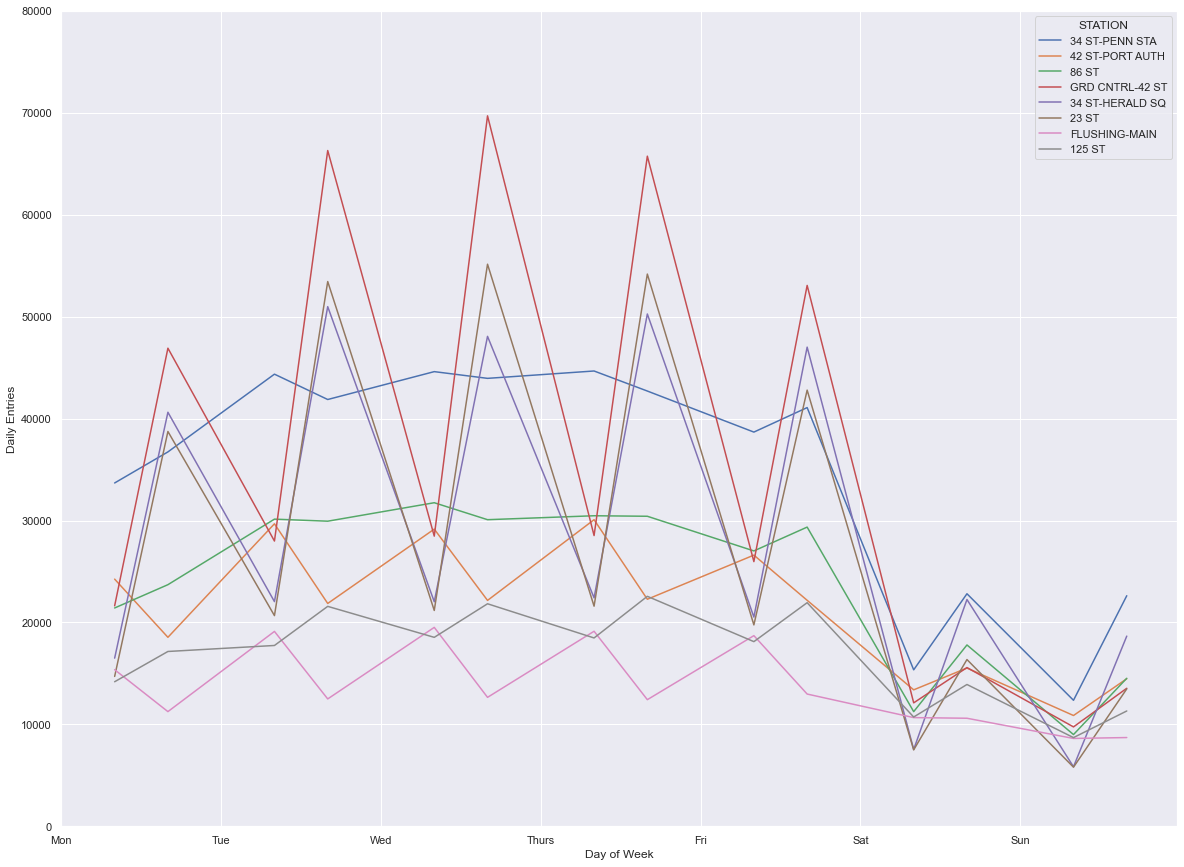

In [313]:

the_plt = sns.lineplot(data=top_stations_dow_time_drop, x="DOW_TIME", y="HOURLY_ENTRIES", hue="STATION");

plt.xlabel("Day of Week")
plt.ylabel("Daily Entries")
the_plt.set_xticks(range(7))
the_plt.set_xticklabels(["Mon", "Tue", "Wed", "Thurs", "Fri", "Sat", "Sun"]);

the_plt.set(ylim=(0, 80000))

# this plot indicated difference in behavior in morning/afternoon

In [314]:
top_stations_morning = \
    (stations_hourly.groupby(['STATION', 'TIME'])['HOURLY_ENTRIES'].mean()).reset_index()
top_stations_morning = top_stations_morning[top_stations_morning["TIME"] == "08:00:00"] \
                    .sort_values(by="HOURLY_ENTRIES", ascending=False)
top_stations_morning = list(top_stations_morning.head(8)["STATION"])
# find top morning stations that aren't also top afternoon stations?

In [315]:
top_stations_afternoon = \
    (stations_hourly.groupby(['STATION', 'TIME'])['HOURLY_ENTRIES'].mean()).reset_index()
top_stations_afternoon = top_stations_afternoon[top_stations_afternoon["TIME"] == "16:00:00"] \
                    .sort_values(by="HOURLY_ENTRIES", ascending=False)
top_stations_afternoon = list(top_stations_afternoon.head(8)["STATION"])

In [316]:
top_stations_all = np.unique(top_stations_morning + top_stations_afternoon)
len(top_stations_all)

12

[(0.0, 80000.0)]

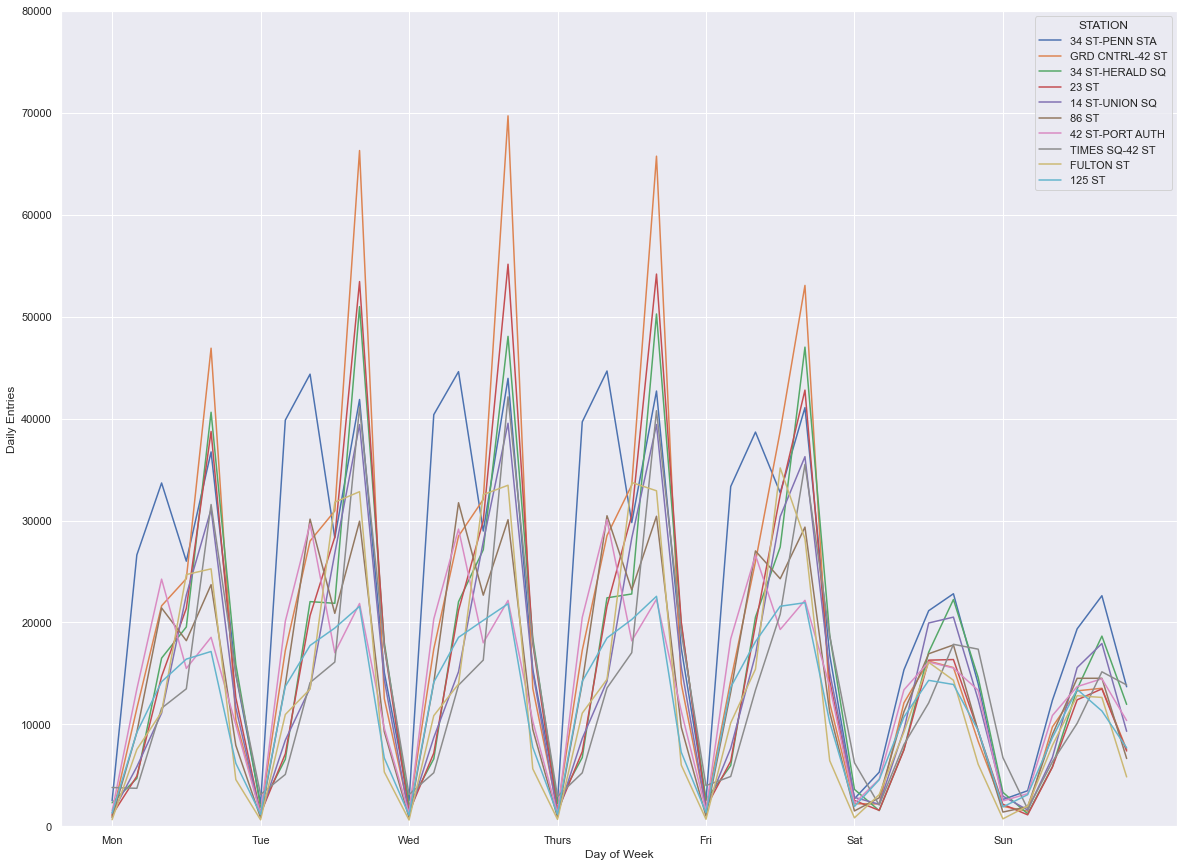

In [317]:
stations_dow_time = (stations_hourly.groupby(["STATION", "DOW_TIME"])).mean()
top_stations_dow_time = stations_dow_time.loc[top_stations].reset_index()

the_plt = sns.lineplot(data=top_stations_dow_time, x="DOW_TIME", y="HOURLY_ENTRIES", hue="STATION");

plt.xlabel("Day of Week")
plt.ylabel("Daily Entries")
the_plt.set_xticks(range(7))
the_plt.set_xticklabels(["Mon", "Tue", "Wed", "Thurs", "Fri", "Sat", "Sun"]);

the_plt.set(ylim=(0, 80000))

# this plot indicated difference in behavior in morning/afternoon

In [416]:
from scipy.optimize import linear_sum_assignment

# can just group by weekday since we're only doing morning
morning_group = stations_hourly[stations_hourly["TIME"] == "08:00:00"].groupby(["DOW_INDEX", "STATION"])["HOURLY_ENTRIES"].mean()
station_list = list(morning_group.loc[0].index)
cost_array_m = np.array([list(-morning_group.loc[day]) for day in [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]])
days, station_indices_m = linear_sum_assignment(cost_array_m)
morning_rec = [station_list[idx] for idx in station_indices_m]
print(morning_rec)
-sum(cost_array_m[i][station_indices_m[i]] for i in range(10))
-cost_array_m[days, station_indices_m].sum()

['FLUSHING-MAIN', '96 ST', '34 ST-PENN STA', '34 ST-HERALD SQ', '86 ST', 'GRD CNTRL-42 ST', '42 ST-PORT AUTH', '23 ST', '14 ST-UNION SQ', '125 ST']


241832.33333333337

array([ 58, 217,  56, 173, 224,  69,  43, 330,  14,  82])

In [418]:
from scipy.optimize import linear_sum_assignment

# can just group by weekday since we're only doing morning
afternoon_group = stations_hourly[stations_hourly["TIME"] == "16:00:00"].groupby(["DOW_INDEX", "STATION"])["HOURLY_ENTRIES"].mean()
station_list = list(afternoon_group.loc[0].index)
cost_array_a = np.array([list(-afternoon_group.loc[day]) for day in [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]])
days, station_indices_a = linear_sum_assignment(cost_array_a)
afternoon_rec = [station_list[idx] for idx in station_indices_a]
print(afternoon_rec)
-sum(cost_array_a[i][station_indices_a[i]] for i in range(10))
-cost_array_a[days, station_indices_a].sum()

['34 ST-PENN STA', 'FULTON ST', '34 ST-HERALD SQ', 'CHAMBERS ST', 'GRD CNTRL-42 ST', '47-50 STS ROCK', '23 ST', 'TIMES SQ-42 ST', '14 ST-UNION SQ', '59 ST']


415517.6666666667

In [413]:
print([morning_group[int(i/2)][morning_rec[i]] for i in range(10)])
sum([morning_group[int(i/2)][morning_rec[i]] for i in range(10)])

[15365.666666666666, 13211.666666666666, 44360.333333333336, 22044.666666666668, 31746.666666666668, 28468.0, 30081.666666666668, 21596.0, 16840.333333333332, 18117.333333333332]


241832.33333333334

In [414]:
print([afternoon_group[int(i/2)][afternoon_rec[i]] for i in range(10)])
sum([afternoon_group[int(i/2)][afternoon_rec[i]] for i in range(10)])

[36732.0, 25258.333333333332, 50984.666666666664, 33872.0, 69704.33333333333, 37824.666666666664, 54180.0, 40772.333333333336, 36266.333333333336, 29923.0]


415517.6666666666

In [396]:
[cost_array[i][station_indices[i]] for i in range(10)]

[-36732.0,
 -25258.333333333332,
 -50984.666666666664,
 -33872.0,
 -69704.33333333333,
 -37824.666666666664,
 -54180.0,
 -40772.333333333336,
 -36266.333333333336,
 -29923.0]

In [370]:
morning_group[0]['34 ST-PENN STA']

33684.666666666664

In [369]:
morning_rec

['34 ST-PENN STA',
 'FULTON ST',
 '34 ST-HERALD SQ',
 'CHAMBERS ST',
 'GRD CNTRL-42 ST',
 '47-50 STS ROCK',
 '23 ST',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ',
 '59 ST']